# STUDENT COMPLAINT AND REVIEW MANAGEMENT SYSTEM WITH SENTIMENT ANALYSIS AND TEXT SUMMARISATION

In [117]:
# notebook imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import string 
from nltk.stem import WordNetLemmatizer
import sklearn
import joblib
from wordcloud import WordCloud

## Getting the data, cleaning and processing

In [66]:
dataframe = pd.read_csv("data/train.csv")

dataframe.head(5)

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km�),Density (P/Km�)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [67]:
dataframe.tail()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km�),Density (P/Km�)
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,night,31-45,Ghana,31072940,227540.0,137
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,morning,46-60,Greece,10423054,128900.0,81
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,noon,60-70,Grenada,112523,340.0,331
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,night,70-100,Guatemala,17915568,107160.0,167
27480,6f7127d9d7,All this flirting going on - The ATG smiles...,All this flirting going on - The ATG smiles. Y...,neutral,morning,0-20,Guinea,13132795,246000.0,53


## Get dataset info

In [68]:
dataframe.shape

(27481, 10)

In [69]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27481 non-null  object 
 2   selected_text     27481 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km�)   27481 non-null  float64
 9   Density (P/Km�)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [70]:
dataframe[dataframe.isnull().any(axis=1)]  # no missing row

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km�),Density (P/Km�)


## Dropping unnecessary columns

In [71]:
dataframe = dataframe[['text', 'sentiment']]
dataframe.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


## Converting the sentiments to numbers: 
### -1 for negative 
### 0 for neutral 
### 1 for positive

In [72]:
dataframe['sentiment'] = dataframe['sentiment'].replace('negative', -1)

dataframe['sentiment'] = dataframe['sentiment'].replace('neutral', 0)

dataframe['sentiment'] = dataframe['sentiment'].replace('positive', 1)

dataframe.head()

,text,sentiment
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,-1
2,my boss is bullying me...,-1
3,what interview! leave me alone,-1
4,"Sons of ****, why couldn`t they put them on t...",-1


In [73]:
dataframe.tail()

,text,sentiment
27476,wish we could come see u on Denver husband l...,-1
27477,I`ve wondered about rake to. The client has ...,-1
27478,Yay good for both of you. Enjoy the break - y...,1
27479,But it was worth it ****.,1
27480,All this flirting going on - The ATG smiles...,0


In [ ]:
# dataframe.iloc[dataframe['sentiment'] == 'negative', 'sentiment'] = int(-1)
# dataframe.head()

## Visualizing our Data

Text(0.5, 1.0, 'Class Distributions \n -1:Negative 0: Neutral      1: Positive')

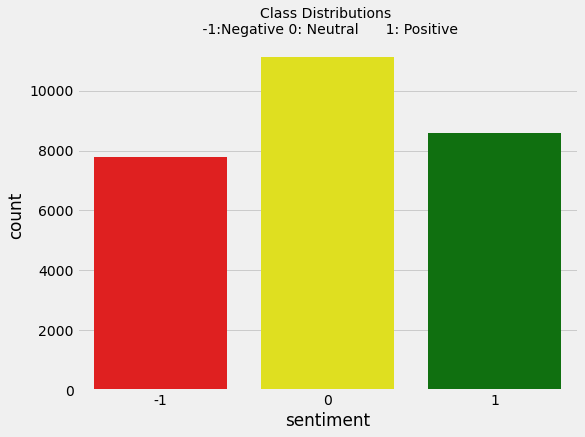

In [32]:
colors = ['red', 'yellow', 'green']

plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=dataframe, palette=colors)
plt.title('Class Distributions \n -1:Negative 0: Neutral      1: Positive', fontsize=14, color='k')

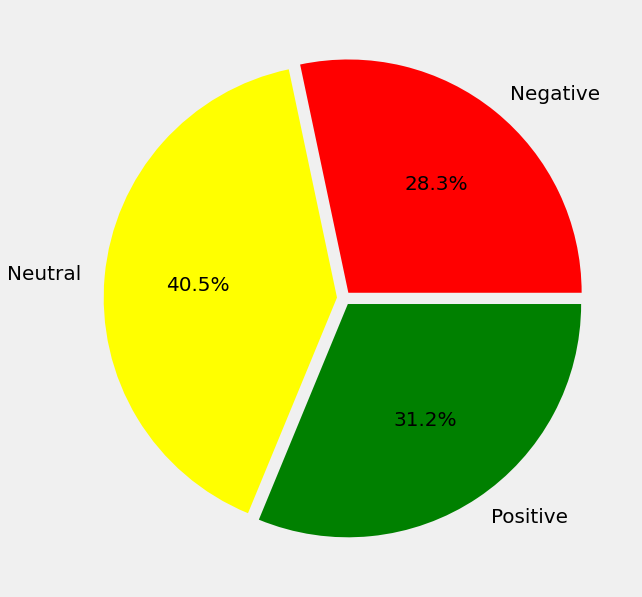

In [41]:
colors = ['red', 'yellow', 'green']
category_names = ['Negative', 'Neutral', 'Positive']
sizes = [dataframe.sentiment.value_counts()[-1], dataframe.sentiment.value_counts()[0], dataframe.sentiment.value_counts()[1]]

plt.figure(figsize=(10,10))
plt.pie(sizes, labels=category_names, autopct='%1.1f%%', explode=[.03, .03, .03], colors=colors, textprops={'fontsize': 20})
plt.show()

## Cleaning the data

In [42]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + 
            ' '.join(emoticons).replace('-', ''))
    return text

In [46]:
# example before cleaning

dataframe.loc[0, 'text']

' I`d have responded, if I were going'

In [47]:
# after cleaning

preprocessor(dataframe.loc[0, 'text'])

' i d have responded if i were going'

In [48]:
# applying the preprocessor to our data

dataframe['text'] = dataframe['text'].apply(preprocessor)

TypeError: expected string or bytes-like object

## Processing Tweets into tokens (tokenization)

In [49]:
def tokenizer(text):
    return text.split()

tokenizer('runners like running and thus they run')

['runners', 'like', 'running', 'and', 'thus', 'they', 'run']

In [50]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

tokenizer_porter('runners like running and thus they run')

['runner', 'like', 'run', 'and', 'thu', 'they', 'run']

## Removing stops words: go, the, at, a, and etc

In [51]:
stop = stopwords.words('english')
[w for w in tokenizer_porter('a runner likes running and runs a lot')[-10:] if w not in stop]

['runner', 'like', 'run', 'run', 'lot']

## Next, we will define a tokenizer function that cleans the unprocessed text data and separate it into word tokens while removing stop-words:

In [52]:
stop = stopwords.words('english')

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

## Next, we will define a generator function, stream_docs, that reads in and returns one document at a time:

In [53]:
def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csv:
        next(csv) # skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

## To verify that our stream_docs function works correctly, let's read in the first document from the file, which should return a tuple consisting of the Tweet text as well as the corresponding class label

In [74]:
next(stream_docs(path='data/train.csv'))

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb2 in position 100: invalid start byte

In [75]:
# We will now define a function, get_minibatch, that will take a document stream 
# from the stream_docs function and return a particular number of documents
# specified by the size parameter:

def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

In [76]:
from sklearn.feature_extraction.text import HashingVectorizer
# from distutils.version import LooseVersion as Version
# from sklearn import __version__ as sklearn_version


vect = HashingVectorizer(decode_error='ignore',
                         n_features=2**21,
                         preprocessor=None,
                         tokenizer=tokenizer
                        )
doc_stream = stream_docs(path='data/train.csv')

## Splitting our dataset into training and testing set for training and evaluating our model using sklearn train_test_split method

In [77]:
from sklearn.model_selection import train_test_split

X, y = dataframe.text, dataframe.sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [78]:
X_train = vect.fit_transform(X_train)

C:\Users\Ben\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [79]:
X_test = vect.transform(X_test)

## Evaluating different models: SVM, KNN

### KNN

In [80]:
# KNN

from sklearn.neighbors import KNeighborsClassifier as KNN
knn_clf = KNN()

knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [81]:
y_pred = knn_clf.predict(X_test)

In [82]:
print('Accuracy: %.3f' % knn_clf.score(X_test, y_test))

Accuracy: 0.472


In [92]:
# Checking the accuracy of our KNN
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"F1_score: {f1_score(y_test, y_pred, average='micro')}")

Accuracy: 0.4720436628259551
Recall: 0.4720436628259551
Precision: 0.4720436628259551
F1_score: 0.4720436628259551


<AxesSubplot:>

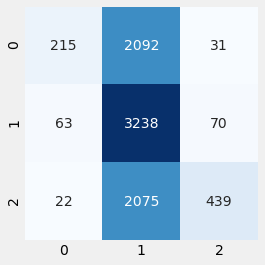

In [94]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [95]:
label = {
    -1: 'Negative',
    0: 'Neutral', 
    1: 'Positive'    
}

example = ["I hate this school"]
X = vect.transform(example)
print('Prediction: %s\nProbability: %.2f%%' %\
      (label[knn_clf.predict(X)[0]], 
       np.max(knn_clf.predict_proba(X))*100))

Prediction: Negative
Probability: 80.00%


In [96]:
label = {
    -1: 'Negative',
    0: 'Neutral', 
    1: 'Positive'    
}

example = ["I love this school"]
X = vect.transform(example)
print('Prediction: %s\nProbability: %.2f%%' %\
      (label[knn_clf.predict(X)[0]], 
       np.max(knn_clf.predict_proba(X))*100))

Prediction: Positive
Probability: 60.00%


In [97]:
label = {
    -1: 'Negative',
    0: 'Neutral', 
    1: 'Positive'    
}

example = ["I have been here before so it is fine"]
X = vect.transform(example)
print('Prediction: %s\nProbability: %.2f%%' %\
      (label[knn_clf.predict(X)[0]], 
       np.max(knn_clf.predict_proba(X))*100))

Prediction: Positive
Probability: 60.00%


### SVM

In [98]:
from sklearn.svm import SVC
svm_clf = SVC()

svm_clf.fit(X_train, y_train)

SVC()

In [99]:
y_pred = svm_clf.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"F1_score: {f1_score(y_test, y_pred, average='micro')}")

Accuracy: 0.6899939357186173
Recall: 0.6899939357186173
Precision: 0.6899939357186173
F1_score: 0.6899939357186173


<AxesSubplot:>

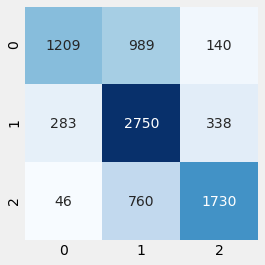

In [100]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [106]:
label = {
    -1: 'Negative',
    0: 'Neutral', 
    1: 'Positive'    
}

example = ["I hate this school because of the way people are treated badly"]
X = vect.transform(example)
print(f'Prediction: {label[svm_clf.predict(X)[0]]}' )

Prediction: Negative


### Decision Tree

In [107]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()

tree_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [108]:
y_pred = tree_clf.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"F1_score: {f1_score(y_test, y_pred, average='micro')}")

Accuracy: 0.6579745300181928
Recall: 0.6579745300181928
Precision: 0.6579745300181928
F1_score: 0.6579745300181928


<AxesSubplot:>

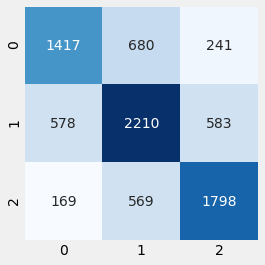

In [109]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [110]:
label = {
    -1: 'Negative',
    0: 'Neutral', 
    1: 'Positive'    
}

example = ["you nigerians are racist and i dislike you all"]
X = vect.transform(example)
print('Prediction: %s\nProbability: %.2f%%' %\
      (label[tree_clf.predict(X)[0]], 
       np.max(tree_clf.predict_proba(X))*100))

Prediction: Negative
Probability: 100.00%


### Stocastic Gradient Descent Classifier

In [126]:
from sklearn.linear_model import SGDClassifier
classes = np.array([0, 1])
sgd_clf = SGDClassifier(loss='log', random_state=1)

sgd_clf.fit(X_train, y_train)

SGDClassifier(loss='log', random_state=1)

In [128]:
y_pred = sgd_clf.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"F1_score: {f1_score(y_test, y_pred, average='micro')}")

Accuracy: 0.6764099454214676
Recall: 0.6764099454214676
Precision: 0.6764099454214676
F1_score: 0.6764099454214676


<AxesSubplot:>

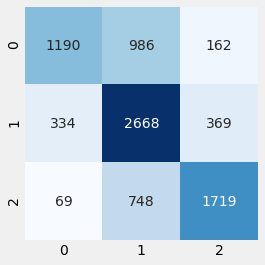

In [129]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [131]:
label = {
    -1: 'Negative',
    0: 'Neutral', 
    1: 'Positive'    
}

example = ["this is one of the best school in the world"]
X = vect.transform(example)
print('Prediction: %s\nProbability: %.2f%%' %\
      (label[sgd_clf.predict(X)[0]], 
       np.max(sgd_clf.predict_proba(X))*100))

Prediction: Positive
Probability: 59.13%


### Using Ensemble Method to Average our models and get better predictions

In [132]:
# combining our models
from sklearn.ensemble import VotingClassifier

ensemble_classifier = VotingClassifier(
    estimators=[('knn_clf', knn_clf),
                ('tree_clf', tree_clf),
                ('svm', svm_clf),
                ('sgd_clf', sgd_clf)],
    voting='hard')

ensemble_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('knn_clf', KNeighborsClassifier()),
                             ('tree_clf', DecisionTreeClassifier()),
                             ('svm', SVC()),
                             ('sgd_clf',
                              SGDClassifier(loss='log', random_state=1))])

In [133]:
ensemble_classifier.score(X_train, y_train)

0.8797567061759202

In [134]:
y_pred = ensemble_classifier.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f"Recall: {recall_score(y_test, y_pred, average='micro')}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro')}")
print(f"F1_score: {f1_score(y_test, y_pred, average='micro')}")

Accuracy: 0.6781079442086113
Recall: 0.6781079442086113
Precision: 0.6781079442086113
F1_score: 0.6781079442086113


<AxesSubplot:>

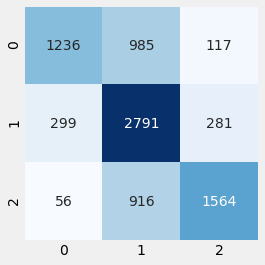

In [135]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

## SVM seems to be our best performing model with 68.9% accuracy

## Lastly, we'll save our models

In [136]:
joblib.dump(knn_clf,'models/knn.joblib')
joblib.dump(svm_clf,'models/svm.joblib')
joblib.dump(tree_clf,'models/tree.joblib')
joblib.dump(sgd_clf,'models/sgd.joblib')
joblib.dump(ensemble_classifier, 'models/ensemble_classifier.joblib')

['models/ensemble_classifier.joblib']

In [138]:
label = {
    -1: 'Negative',
    0: 'Neutral', 
    1: 'Positive'    
}
svm_model = joblib.load('models/svm.joblib')

example = ["I hate this school because of the way people are treated badly"]
X = vect.transform(example)
print(f'Prediction: {label[svm_model.predict(X)[0]]}' )

Prediction: Negative
